In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'


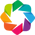

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import loren_frank_data_processing as lfdp
import spectral_connectivity
import ripple_detection
import replay_classification

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('HPa', 6, 4)

In [4]:
from loren_frank_data_processing import (get_LFP_dataframe,
                                         make_neuron_dataframe,
                                         make_tetrode_dataframe, save_xarray)
from src.analysis import (compare_spike_coherence, connectivity_by_ripple_type,
                          decode_ripple_clusterless, detect_epoch_ripples,
                          ripple_locked_firing_rate_change,
                          ripple_spike_coherence,
                          ripple_triggered_connectivity)
from src.spike_models import (fit_ripple_constant, fit_ripple_over_time, fit_replay)
from src.parameters import (ANIMALS, FREQUENCY_BANDS, MULTITAPER_PARAMETERS,
                            REPLAY_COVARIATES, SAMPLING_FREQUENCY,
                            PROCESSED_DATA_DIR)

ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, SAMPLING_FREQUENCY)

replay_info, _, _ = decode_ripple_clusterless(
    epoch_key, ANIMALS, ripple_times)

neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False).query('numspikes > 0')


INFO:src.analysis:Detecting ripples
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
INFO:src.analysis:Decoding ripples
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...
INFO:src.analysis:Predicting replay types


In [5]:
from loren_frank_data_processing import get_interpolated_position_dataframe

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat


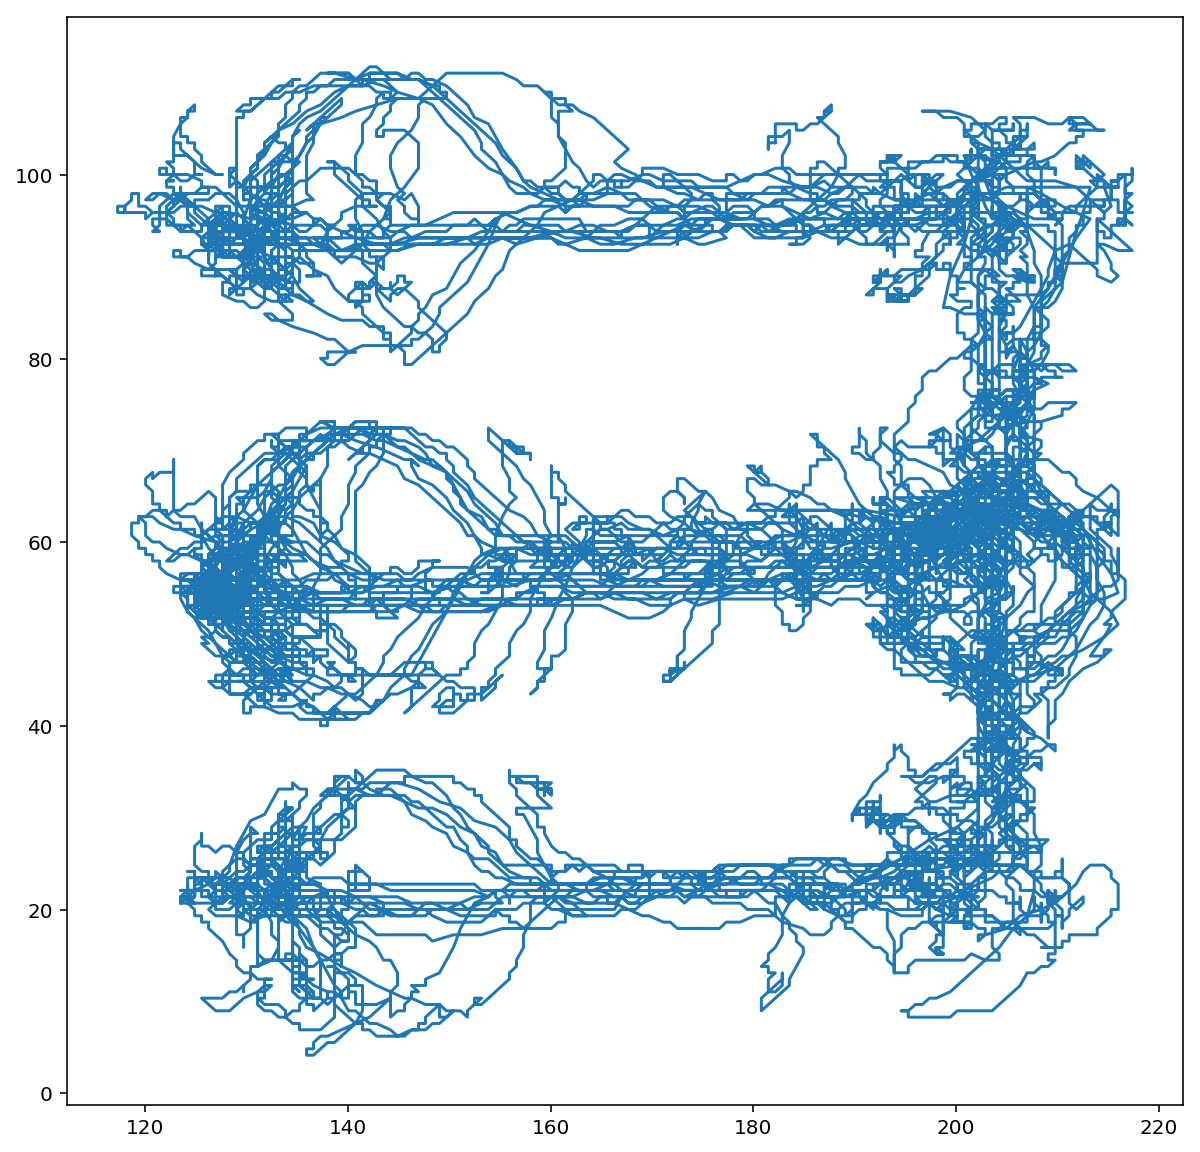

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(position_info.x_position.values, position_info.y_position.values);

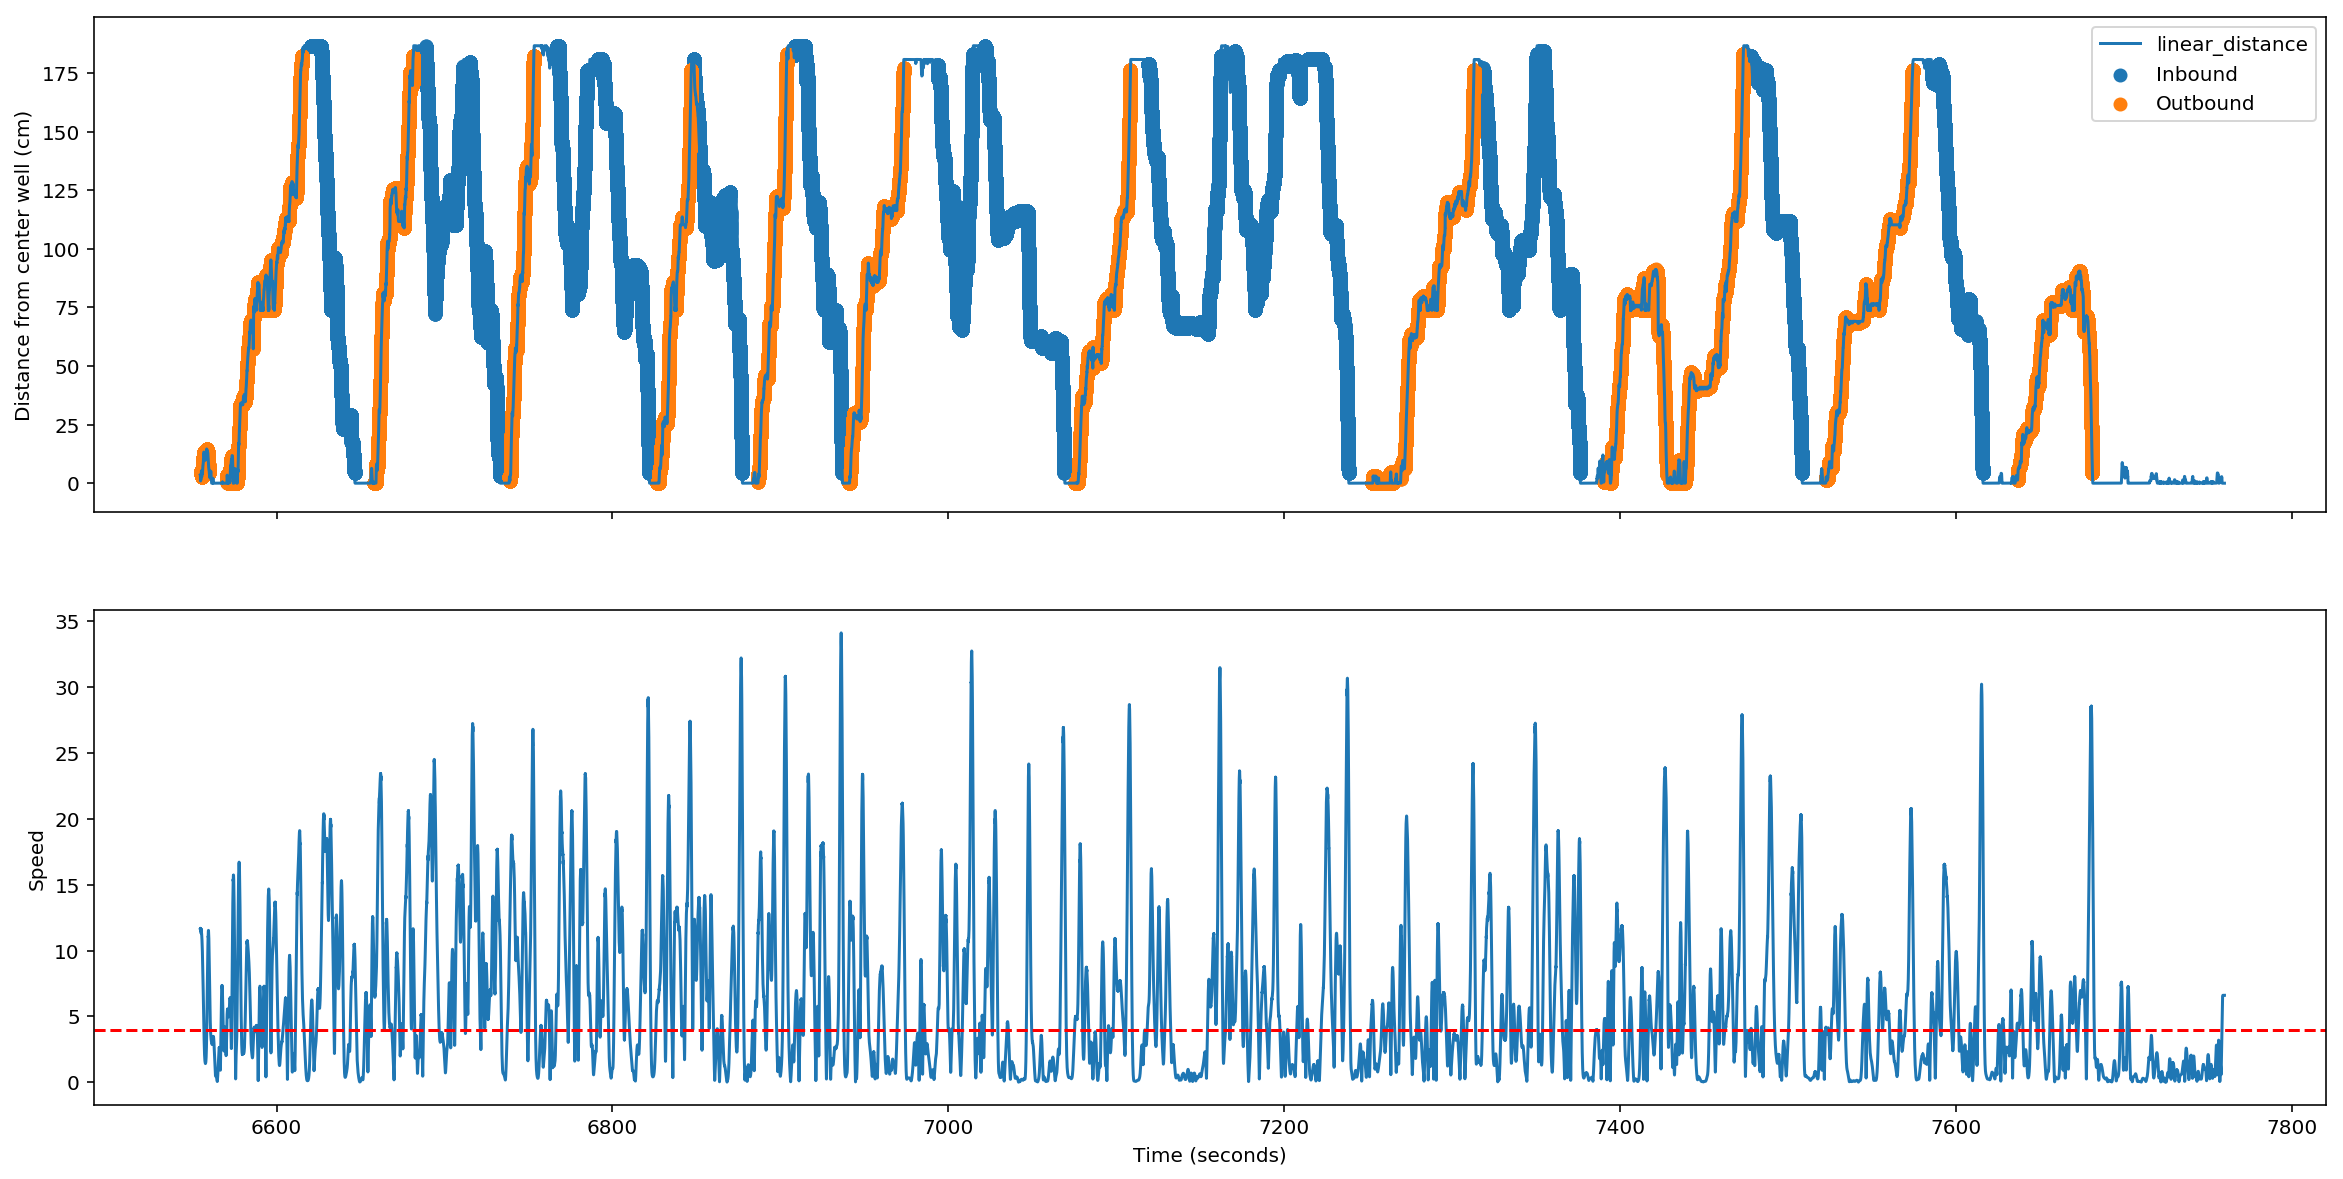

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

axes[0].plot(position_info.index.total_seconds(), position_info.linear_distance)

for label, df in position_info.groupby('task'):
    axes[0].scatter(df.index.total_seconds(), df.linear_distance, label=label)

axes[0].set_ylabel('Distance from center well (cm)')
axes[0].legend();

axes[1].plot(position_info.index.total_seconds(), position_info.speed);
axes[1].set_ylabel('Speed')
axes[1].axhline(4, color='red', linestyle='--')
axes[1].set_xlabel('Time (seconds)');

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=6554.526000000001, n_tapers=5)


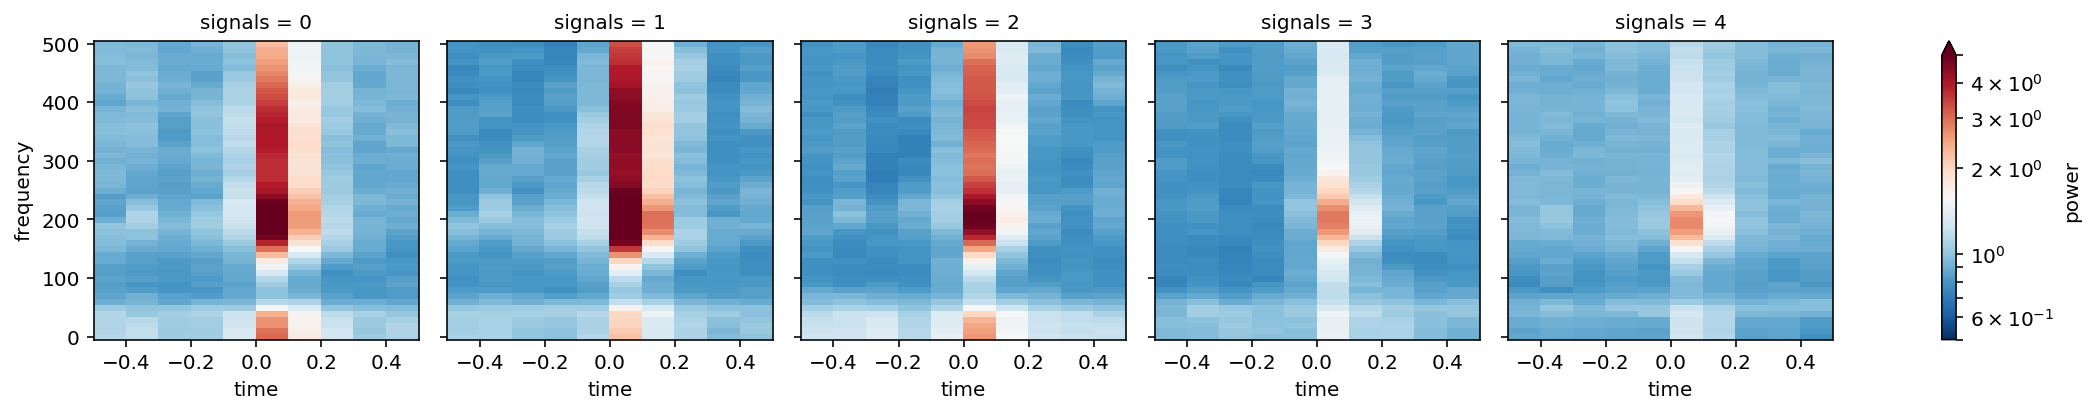

In [8]:
from loren_frank_data_processing import reshape_to_segments, make_tetrode_dataframe, get_LFPs
from matplotlib.colors import LogNorm

window_offset = (-0.5, 0.5)

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
is_brain_areas = (tetrode_info.area.isin(['CA1']) &
                 (tetrode_info.descrip == 'riptet'))
tetrode_keys = tetrode_info[is_brain_areas].index
hippocampus_lfps = get_LFPs(tetrode_keys, ANIMALS)

ripple_locked_LFPs = reshape_to_segments(
    hippocampus_lfps, ripple_times,
    window_offset=window_offset, sampling_frequency=SAMPLING_FREQUENCY)
ripple_locked_LFPs.columns = tetrode_info[is_brain_areas].tetrode_id
ripple_locked_LFPs = (ripple_locked_LFPs.to_xarray()
                      .to_array(dim='signals').transpose('time', 'ripple_number', 'signals'))
m = spectral_connectivity.Multitaper(
    ripple_locked_LFPs.values, SAMPLING_FREQUENCY, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=window_offset[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
ripple_locked_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')


m = spectral_connectivity.Multitaper(
    hippocampus_lfps.values, SAMPLING_FREQUENCY, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=hippocampus_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')

vmin, vmax = 0.5, 5

(ripple_locked_power / power.mean('time')).sel(frequency=slice(0, 500)).plot(
    x='time', y='frequency', col='signals', col_wrap=5, center=0,
    norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
    cmap='RdBu_r');

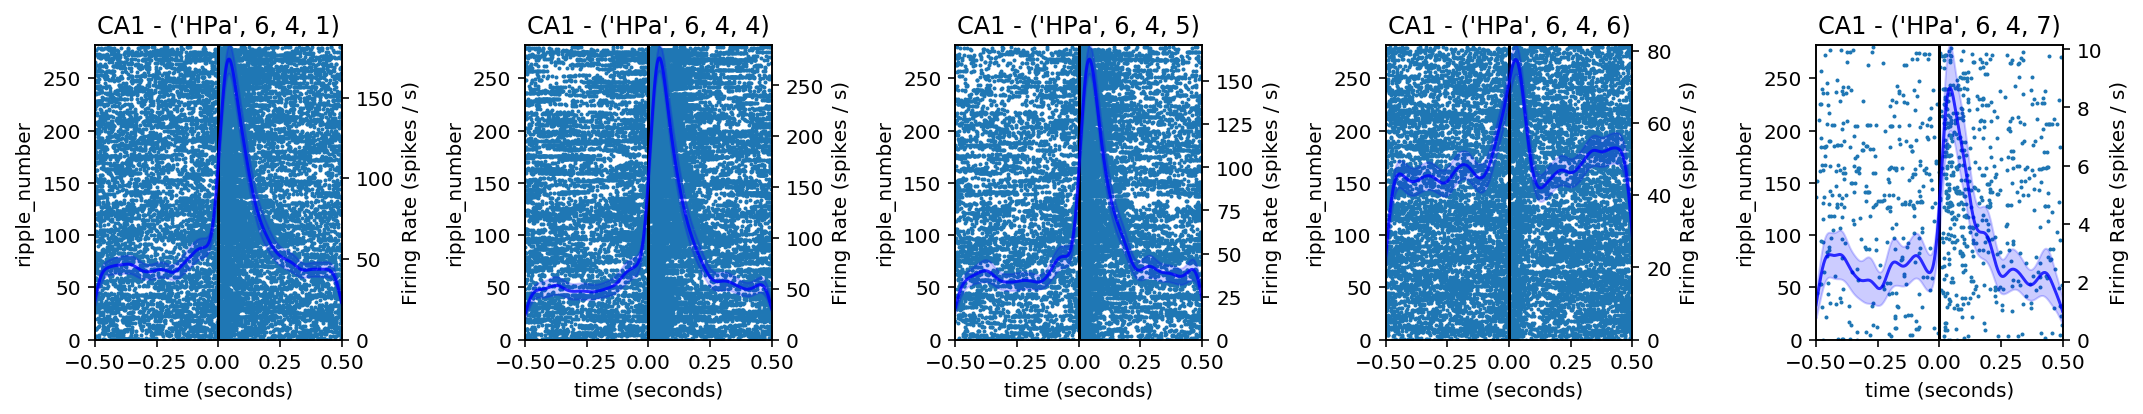

In [9]:
from src.visualization import plot_perievent_raster

ca1_keys = tetrode_info.loc[is_brain_areas].index
n_tetrodes = len(ca1_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), ca1_keys):
    plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

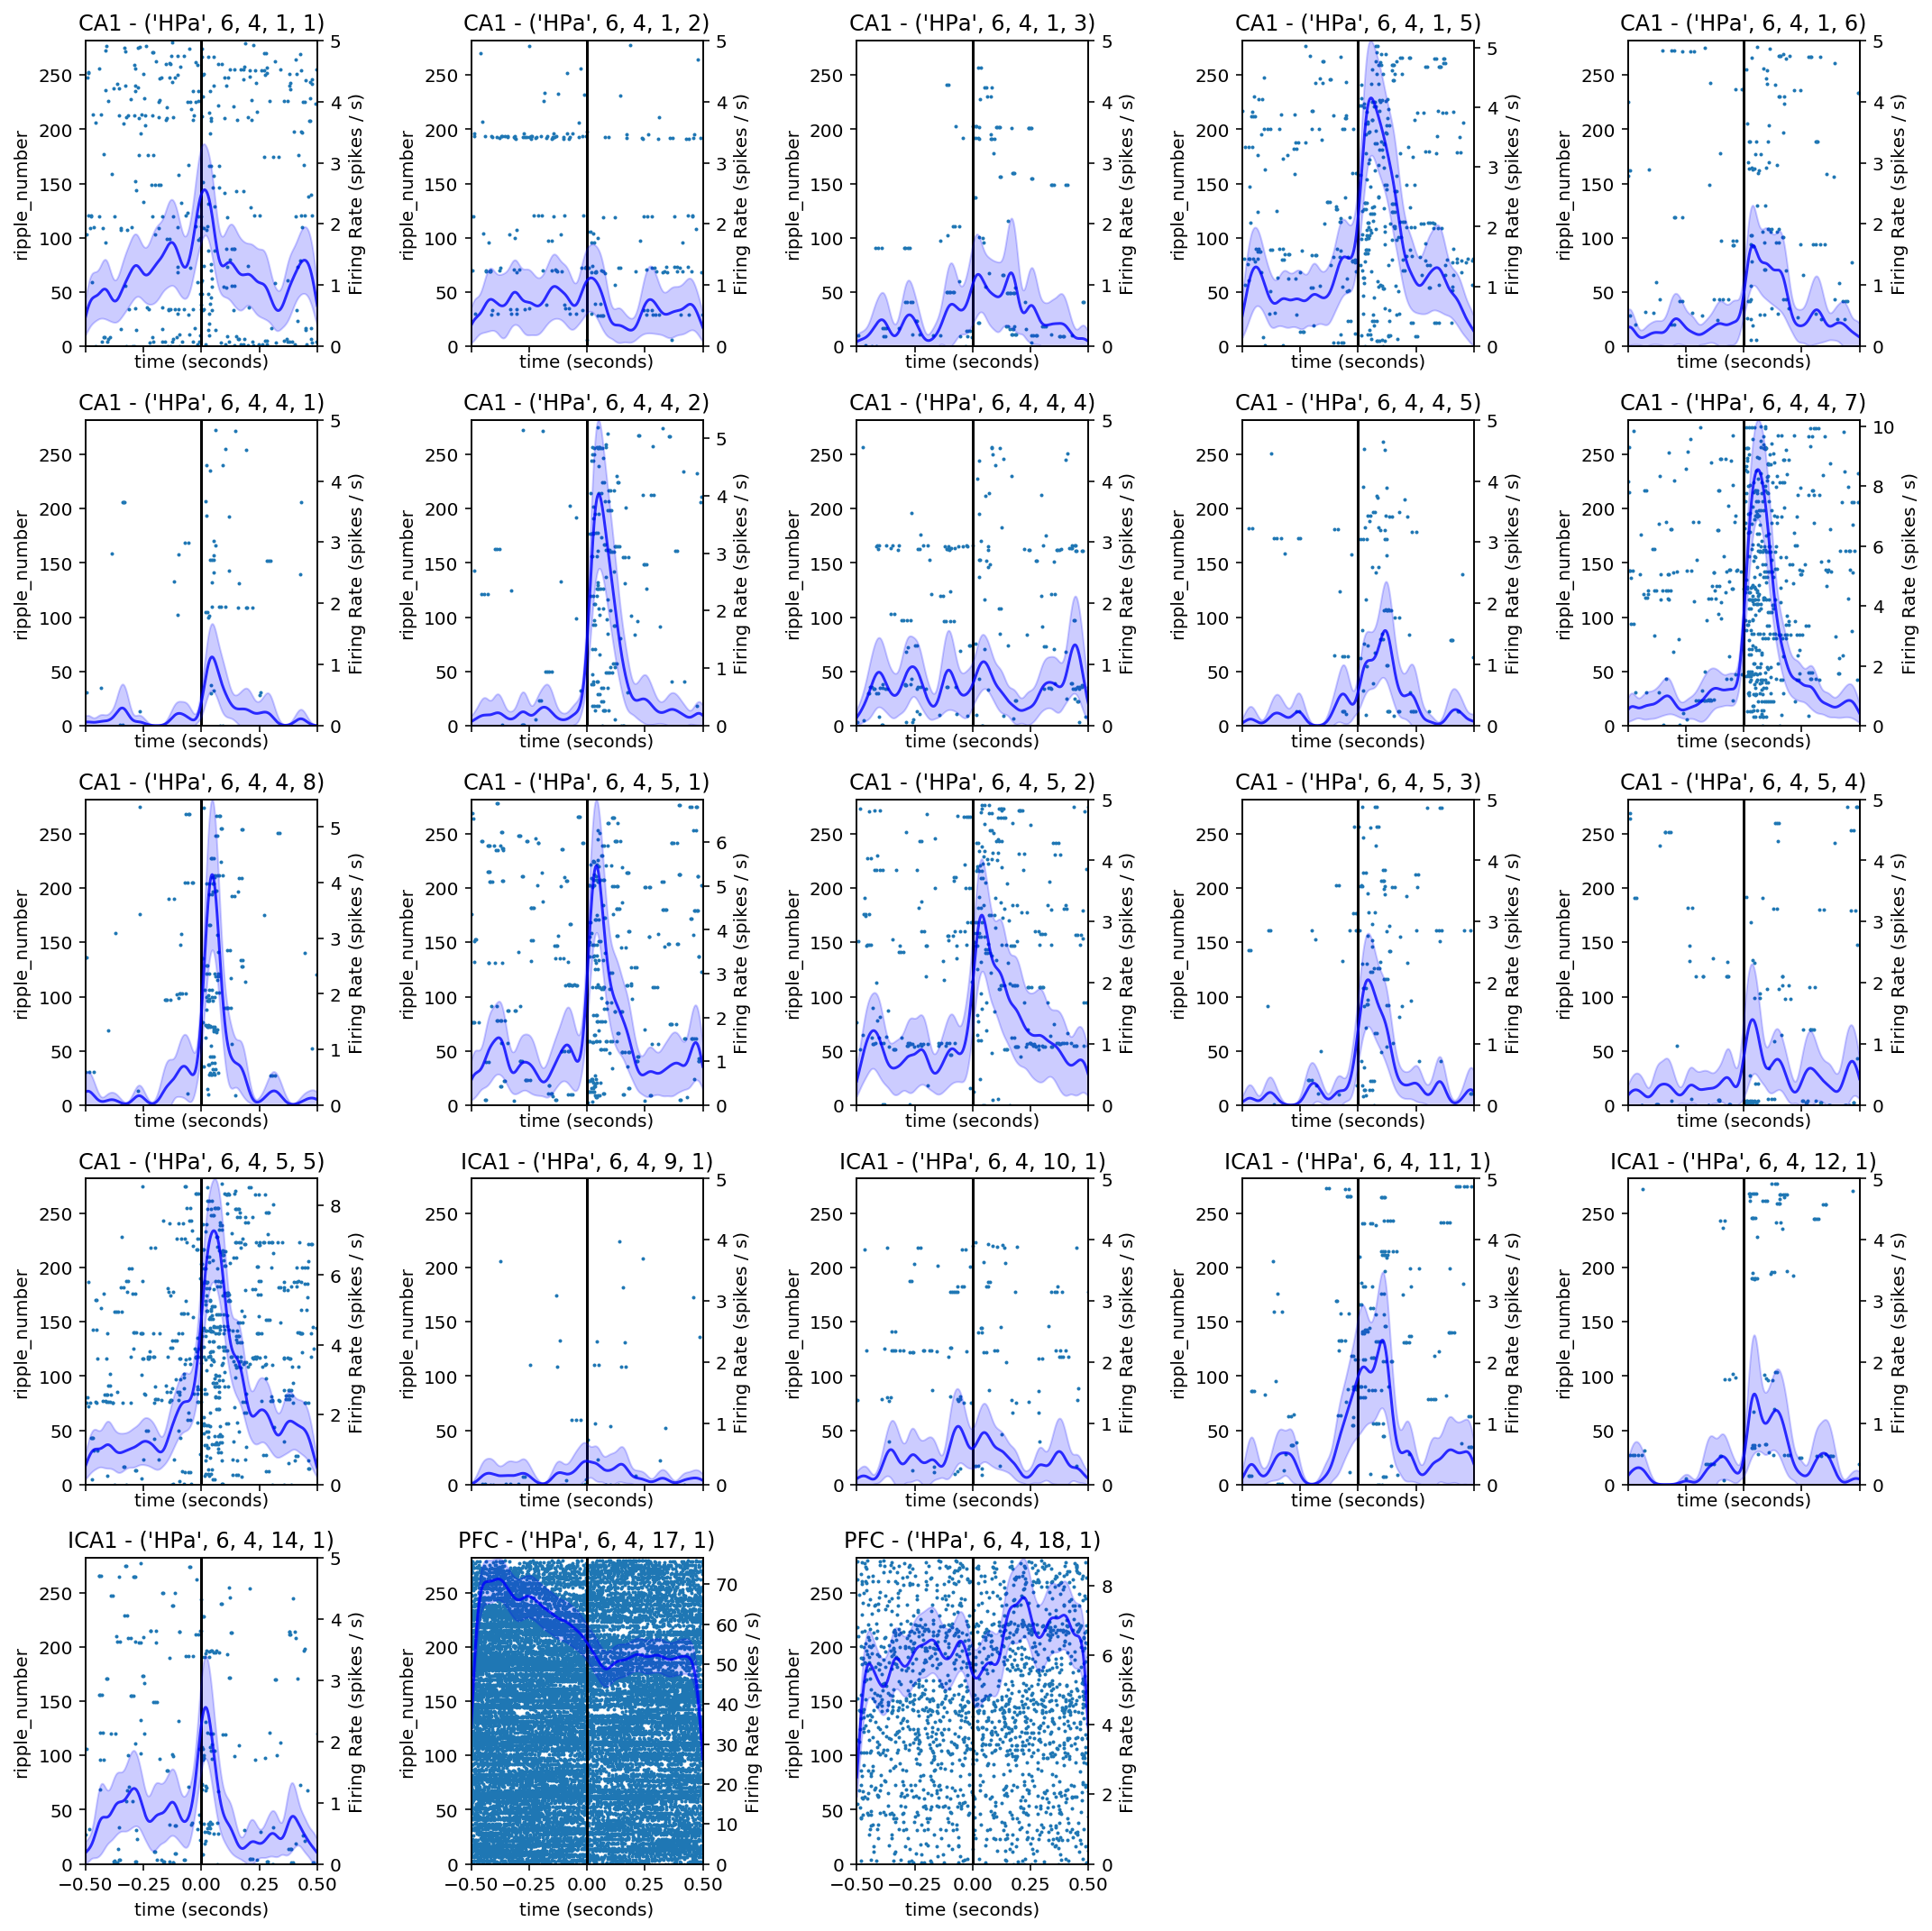

In [10]:
from src.visualization import plot_perievent_raster

neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

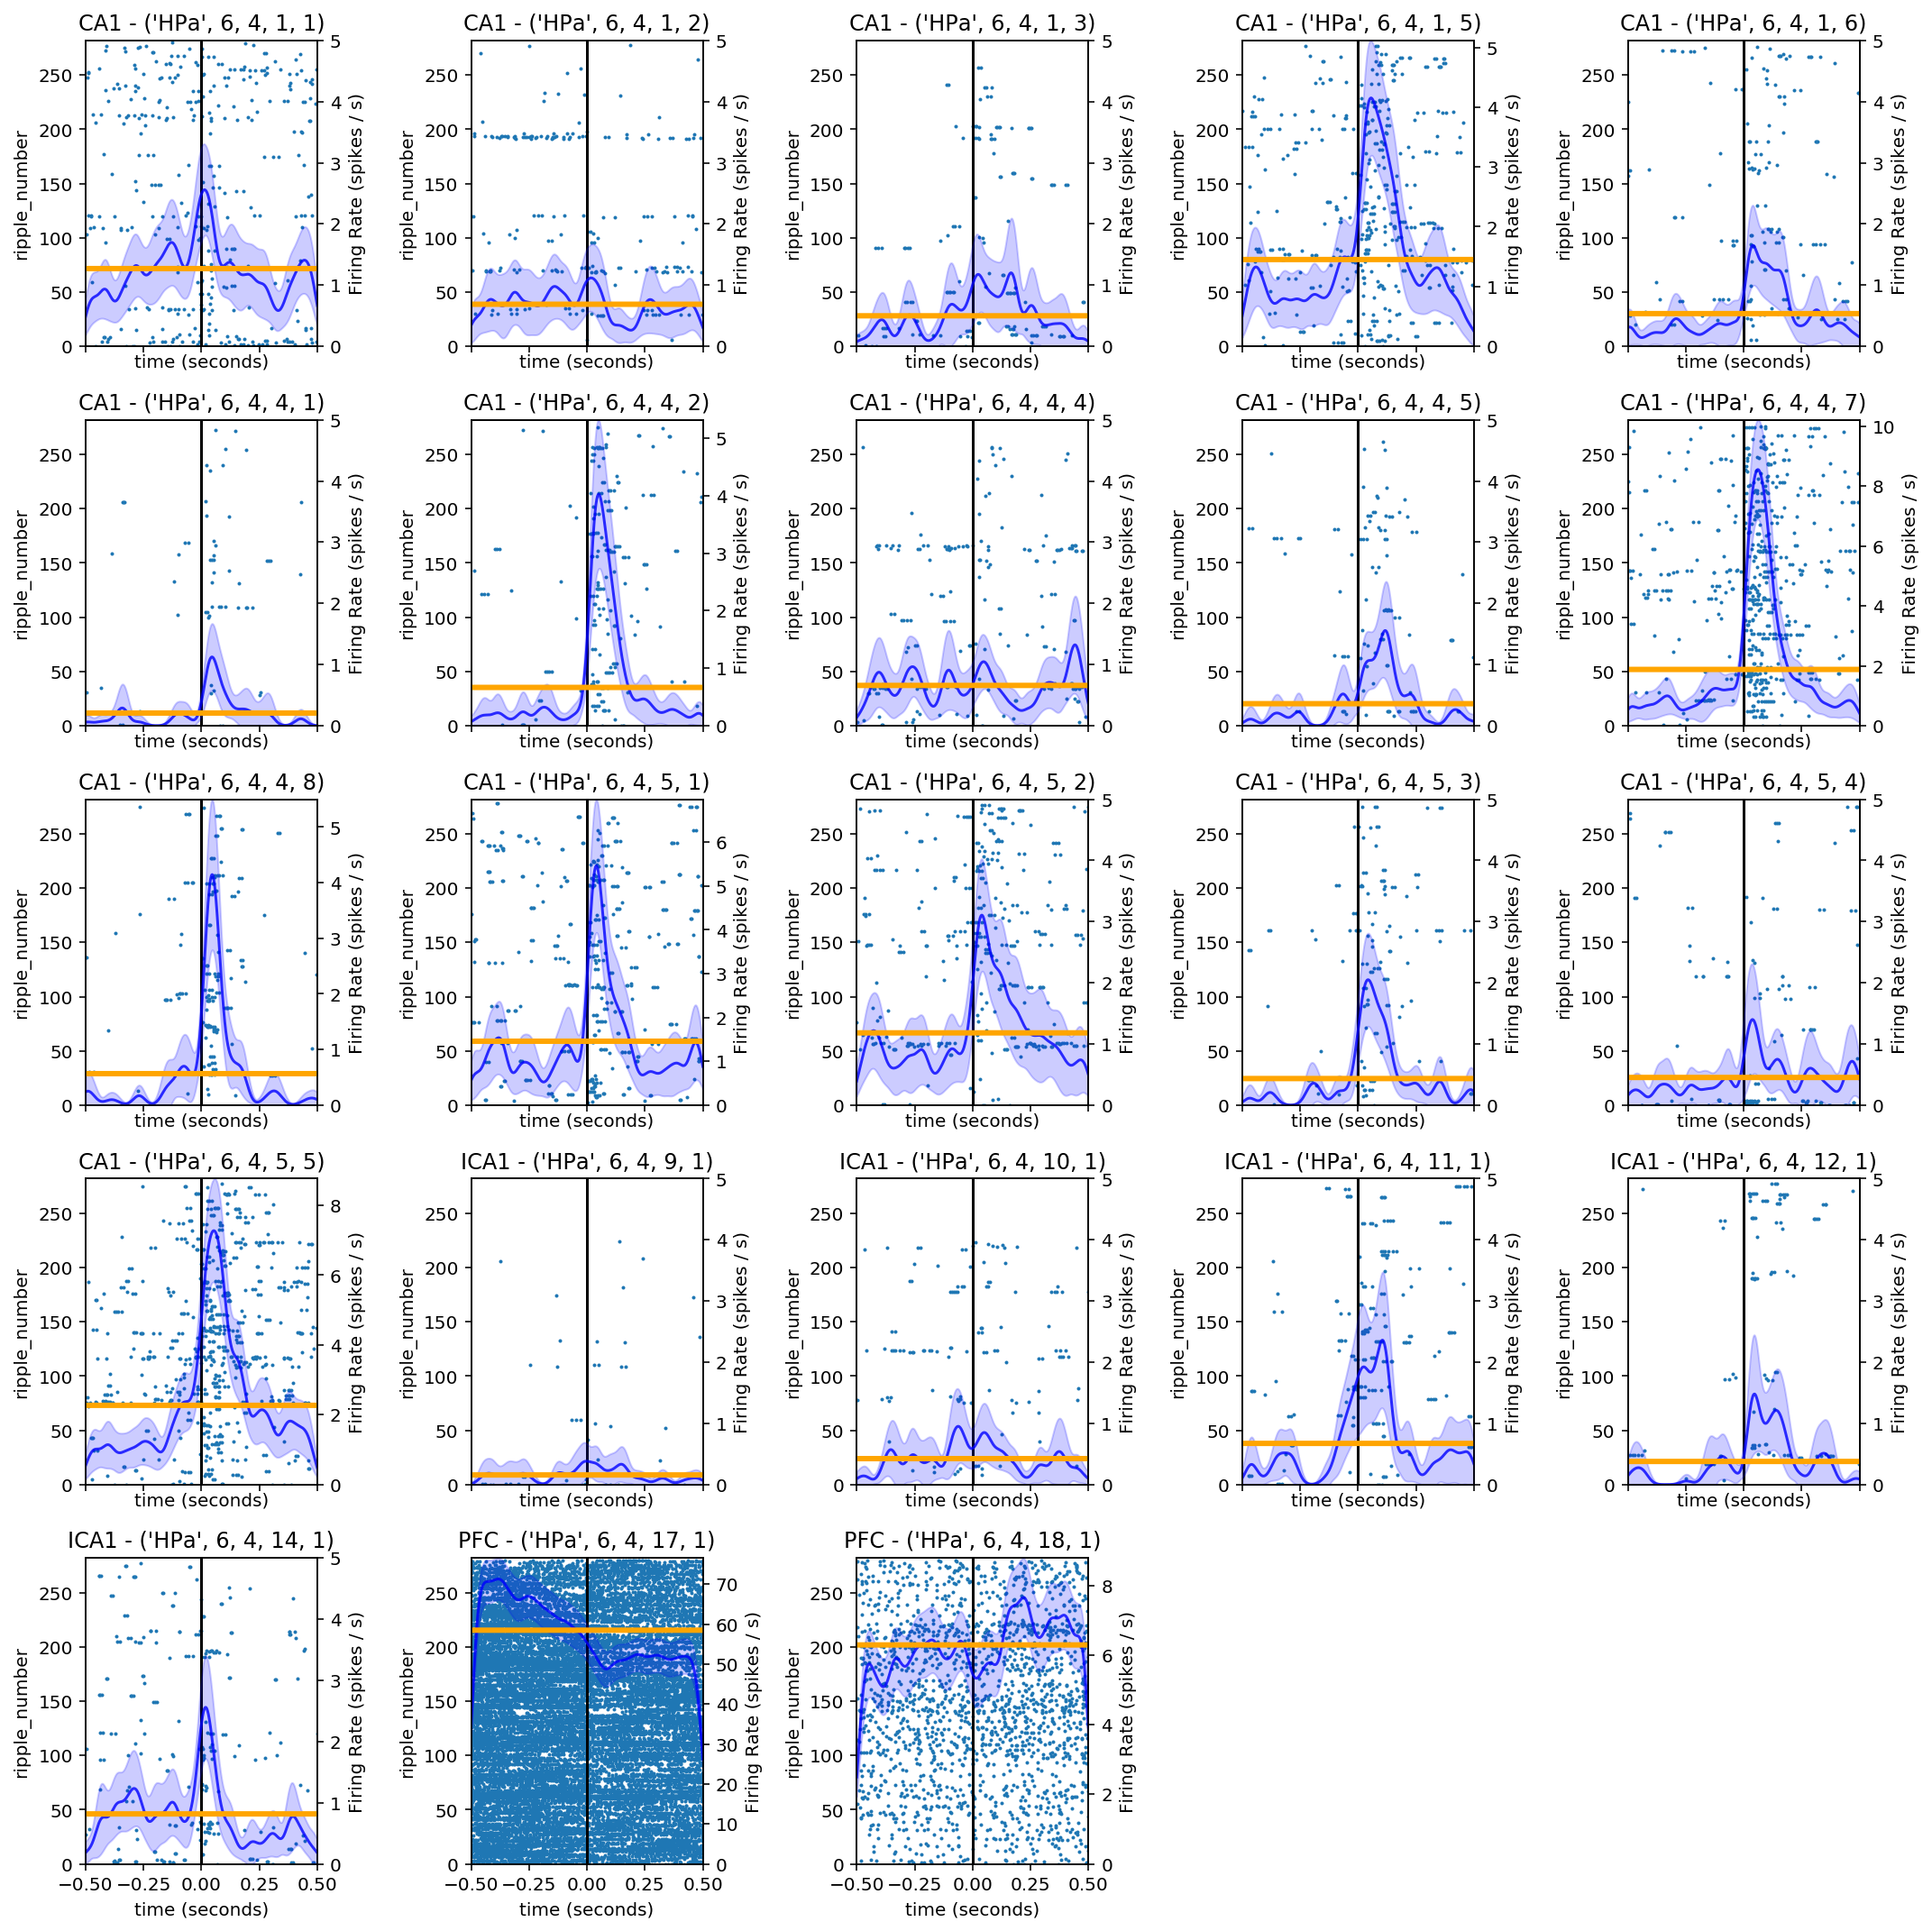

In [12]:
from src.visualization import plot_perievent_raster

neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    ax, ax2 = plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    predicted_rate = results['ripple/constant'].sel(
        neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate
    ax2.plot(results['ripple/constant'].time, predicted_rate, color='orange', linewidth=3)

for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

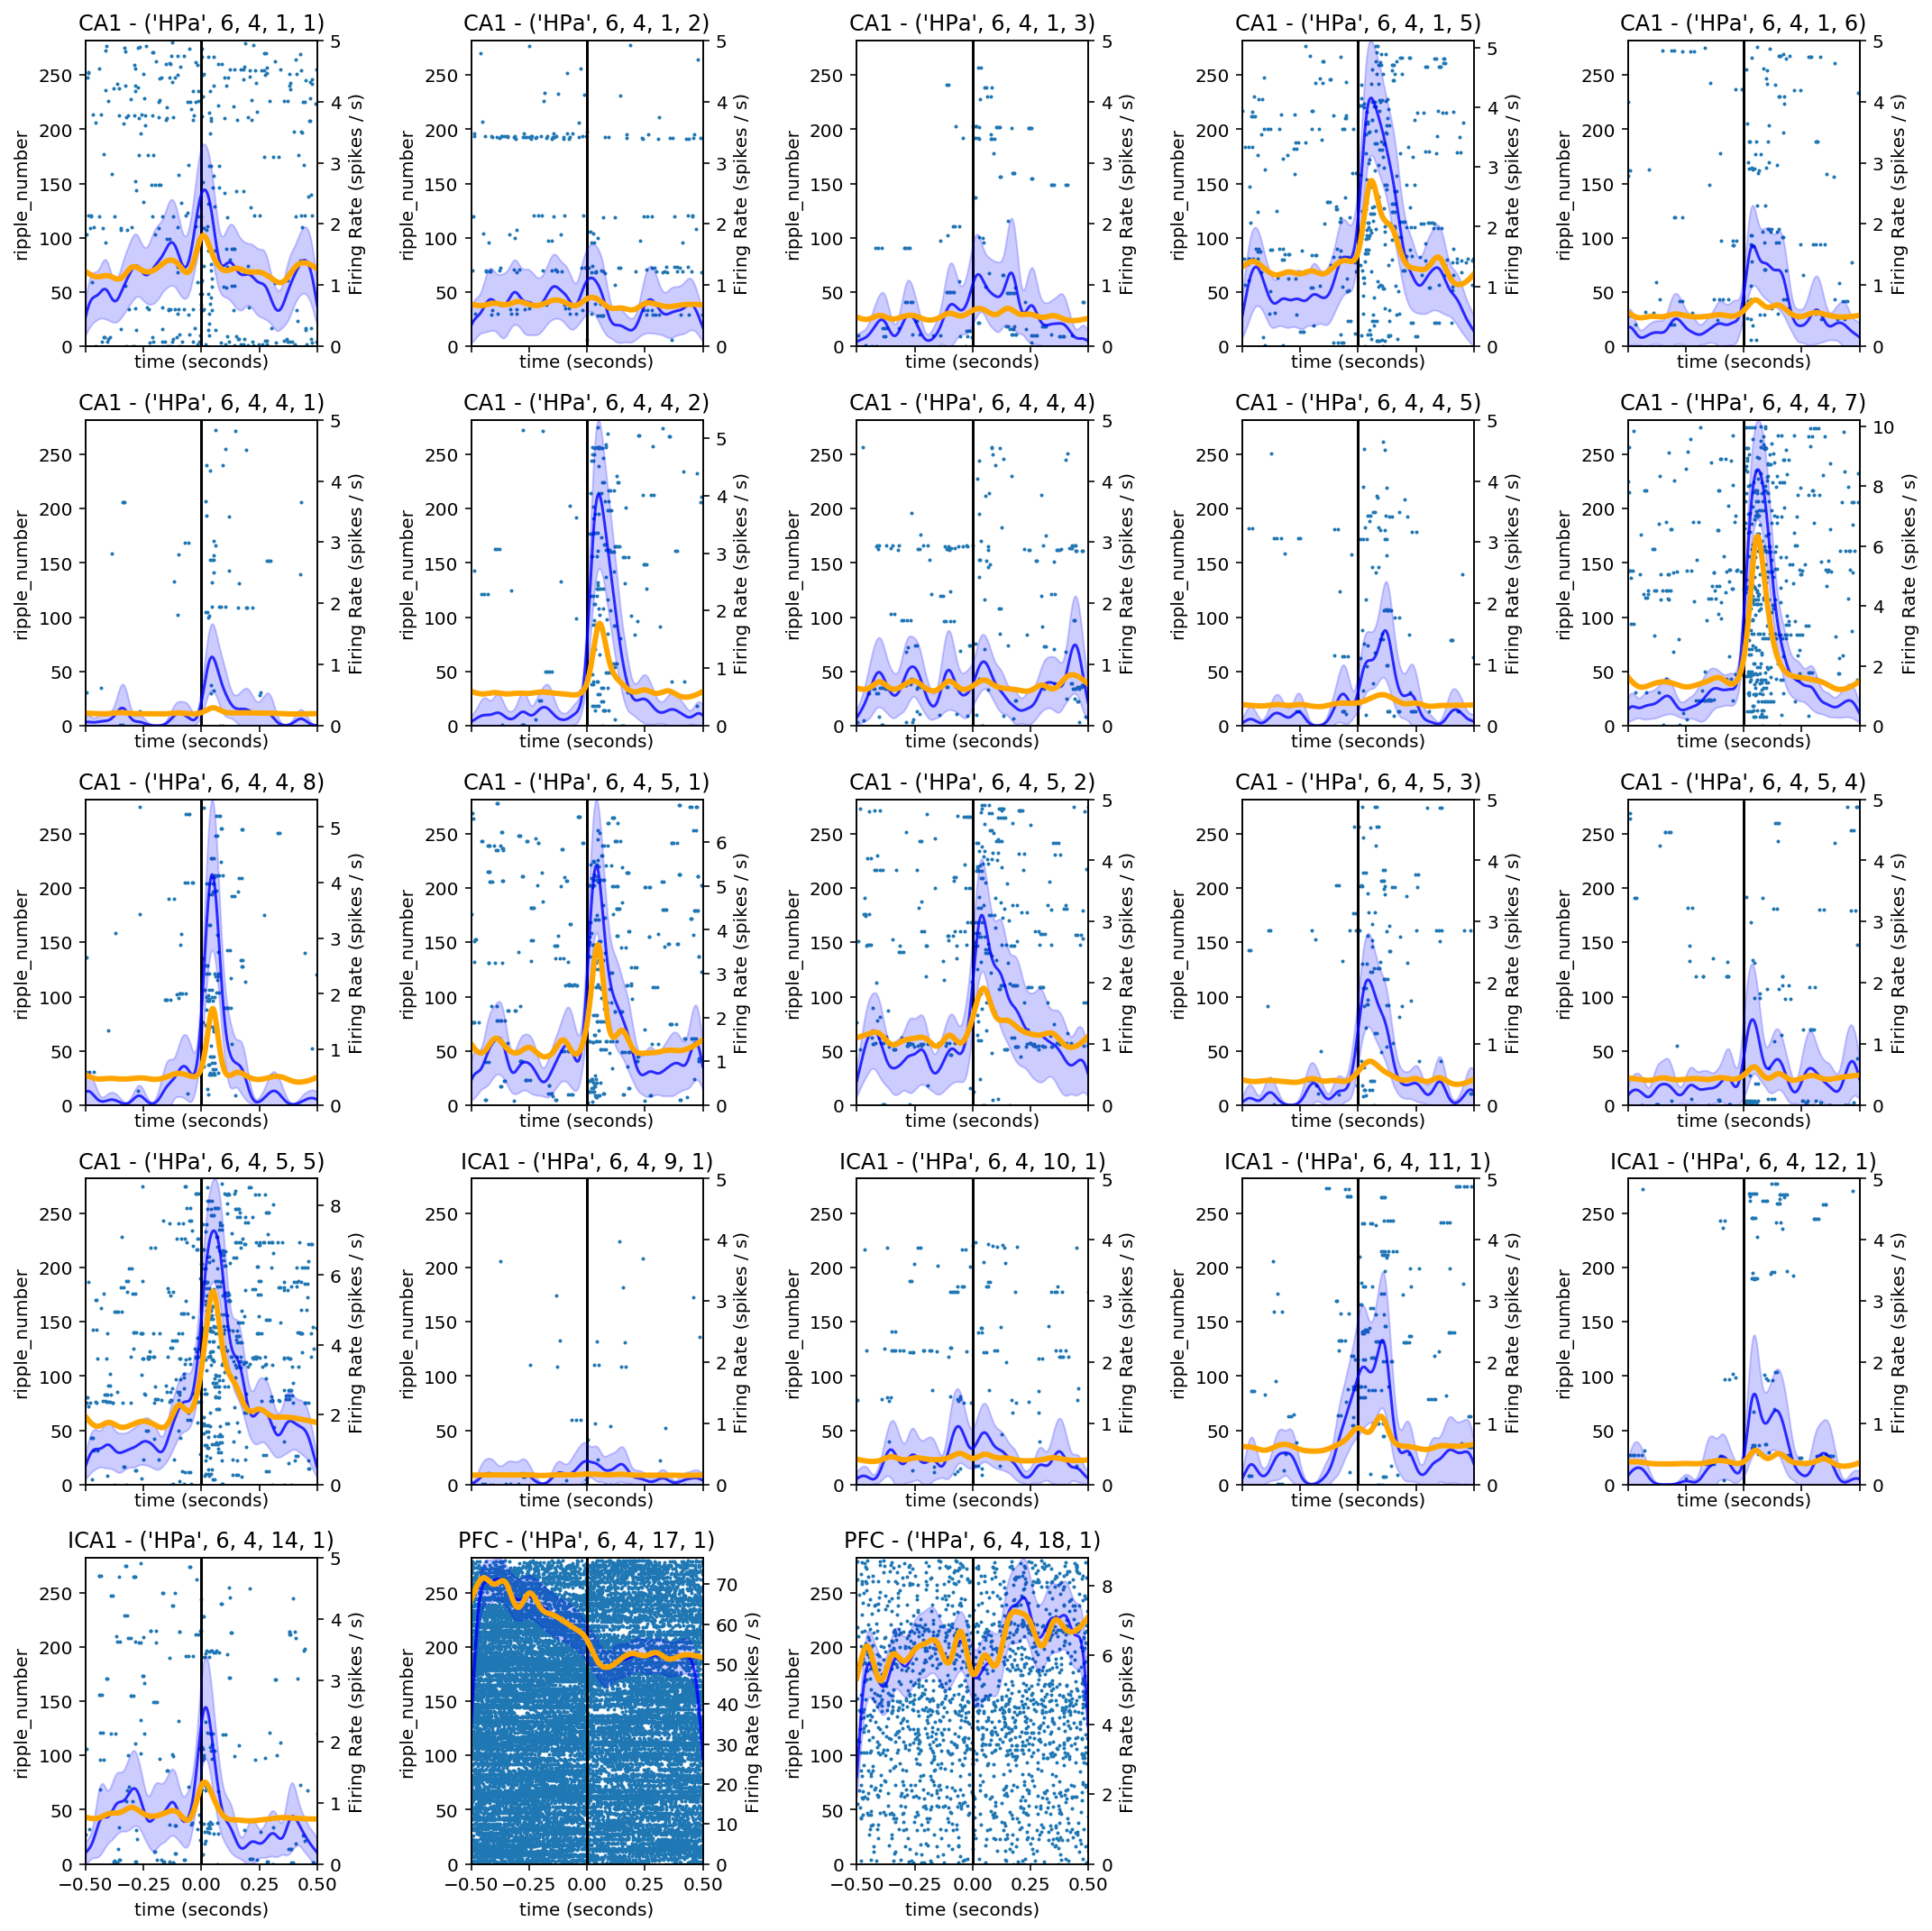

In [13]:
from src.visualization import plot_perievent_raster

neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    ax, ax2 = plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    predicted_rate = results['ripple/over_time'].sel(
        neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate
    ax2.plot(results['ripple/over_time'].time, predicted_rate, color='orange', linewidth=3)
    

for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

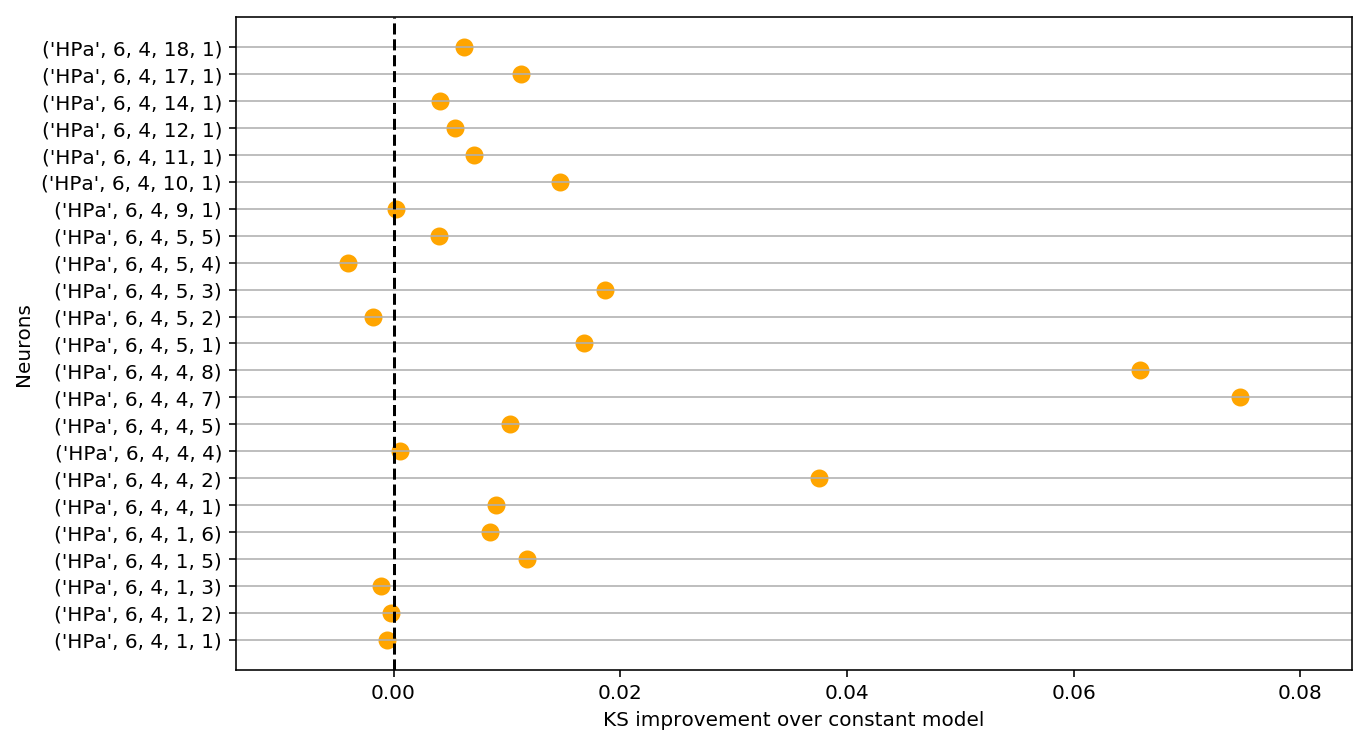

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ks_diff = results['ripple/constant'].ks_statistic.values - results['ripple/over_time'].ks_statistic.values
ax.scatter(ks_diff, np.arange(ks_diff.size),
           color='orange', linewidth=3);
ax.axvline(0, color='black', linestyle='--')
ax.set_ylabel('Neurons')
ax.set_xlabel('KS improvement over constant model');
ax.set_yticks(np.arange(ks_diff.size));
ax.set_yticklabels(neuron_info.index);
ax.yaxis.grid(True)

In [16]:
results['ripple/replay_state'] = xr.concat(
    [fit_replay(
        neuron_key, ANIMALS, SAMPLING_FREQUENCY,  replay_info,
        'predicted_state', penalty=1E-4)
     for neuron_key in neuron_info.index], dim=neuron_info.neuron_id)


INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 1, 1) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 1, 2) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 1, 3) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 1, 5) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 1, 6) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 4, 1) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 4, 2) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 4, 4) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 4, 5) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 4, 7) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 4, 8) - predicted_state
INFO:src.spike_models:Fitting replay model for ('HPa', 6, 4, 5, 1

In [17]:
results['ripple/replay_state']

<xarray.Dataset>
Dimensions:               (neuron_id: 23, predicted_state: 4, time: 1501)
Coordinates:
  * time                  (time) float64 -0.5 -0.4993 -0.4987 -0.498 -0.4973 ...
  * predicted_state       (predicted_state) object 'Outbound-Reverse' ...
  * neuron_id             (neuron_id) object 'HPa_06_04_001_001' ...
Data variables:
    firing_rate           (neuron_id, predicted_state, time) float64 1.246 ...
    multiplicative_gain   (neuron_id, predicted_state, time) float64 0.8993 ...
    baseline_firing_rate  (neuron_id) float64 1.386 0.5868 0.5404 1.274 ...
    ks_statistic          (neuron_id) float64 0.3626 0.5819 0.6387 0.3222 ...
    AIC                   (neuron_id) float64 nan nan nan nan nan nan nan ...

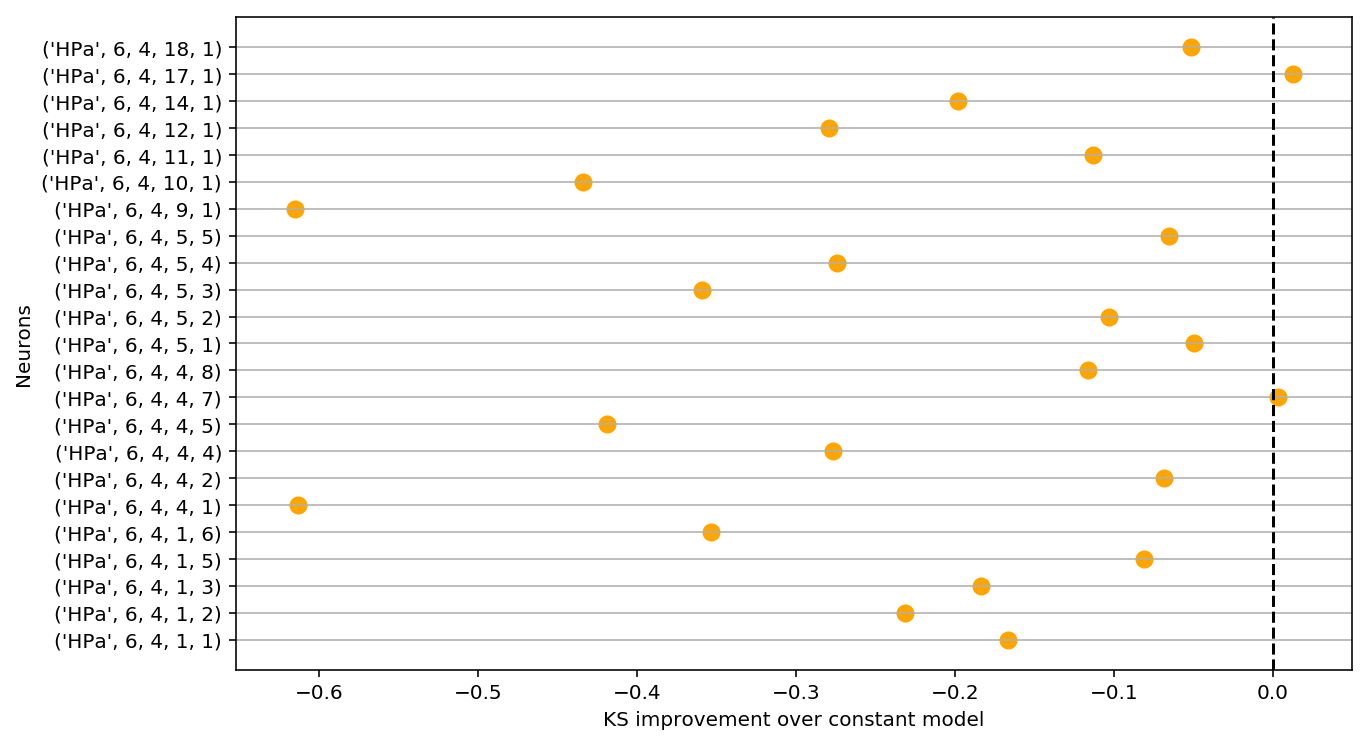

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ks_diff = results['ripple/constant'].ks_statistic.values - results['ripple/replay_state'].ks_statistic.values
ax.scatter(ks_diff, np.arange(ks_diff.size),
           color='orange', linewidth=3);
ax.axvline(0, color='black', linestyle='--')
ax.set_ylabel('Neurons')
ax.set_xlabel('KS improvement over constant model');
ax.set_yticks(np.arange(ks_diff.size));
ax.set_yticklabels(neuron_info.index);
ax.yaxis.grid(True)

In [22]:
replay_info.predicted_state.value_counts()

Unclassified        165
Outbound-Reverse     89
Inbound-Forward      18
Inbound-Reverse       9
Name: predicted_state, dtype: int64

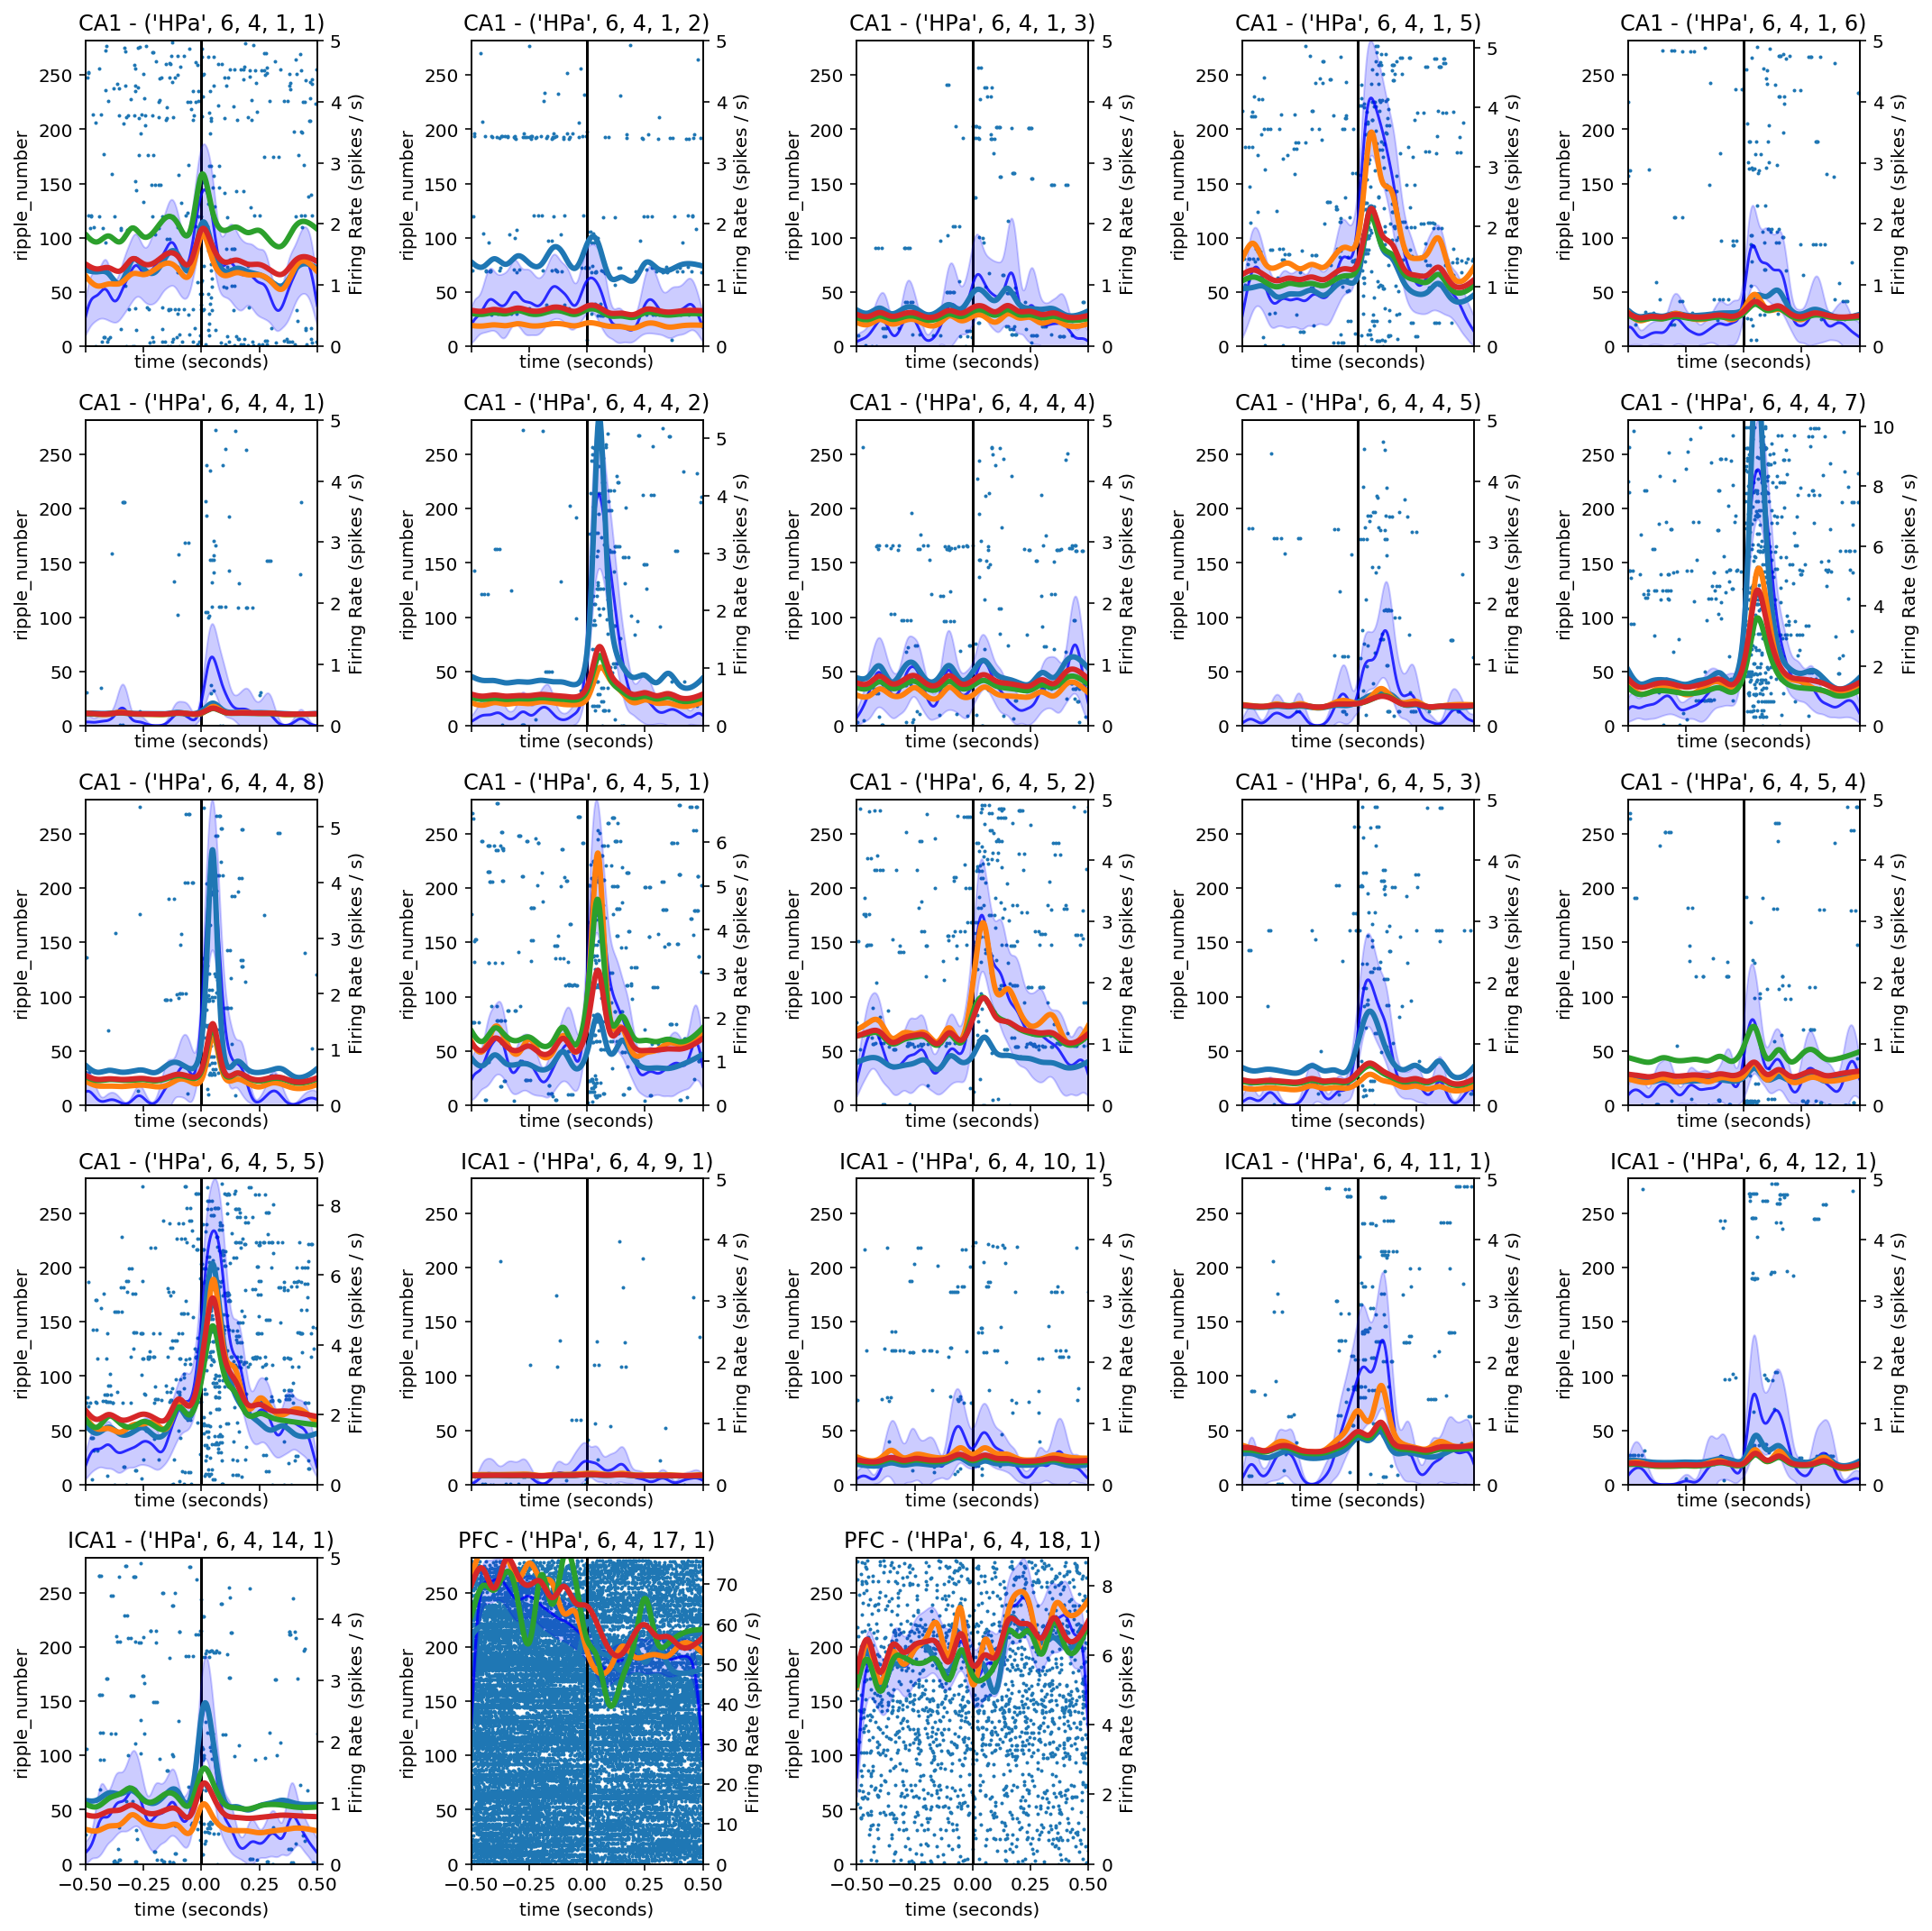

In [31]:
states = results['ripple/replay_state'].predicted_state
time = results['ripple/replay_state'].time



neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    ax, ax2 = plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
    for state in states:
        predicted_rate = results['ripple/replay_state'].sel(
            neuron_id=neuron_info.loc[neuron_key].neuron_id, predicted_state=state).firing_rate
        ax2.plot(results['ripple/over_time'].time, predicted_rate, linewidth=3, label=state)
    

for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

axes[0, 0].legend()
plt.tight_layout()
